## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [21]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [22]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [23]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [24]:
len(fmnist_dataset_test)

10000

In [25]:
for img, label in train_loader:
    print(img.shape)
    #     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [26]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),

            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, num_classes)

        )
        
    def forward(self, inp):       
        return self.model(inp)

Your experiments come here:

In [27]:
from time import perf_counter 
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.style.use("seaborn-v0_8-whitegrid")

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    # --- Validation Loss ---
    axs[0, 0].plot(
        val_loss,
        linewidth=2,
        label="Validation",
    )
    axs[0, 0].set_title("Validation Loss", fontsize=14)
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()
    axs[0, 0].grid(alpha=0.3)

    # --- Train Loss ---
    axs[0, 1].plot(
        train_loss,
        linewidth=2,
        label="Train",
    )
    axs[0, 1].set_title("Train Loss", fontsize=14)
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].legend()
    axs[0, 1].grid(alpha=0.3)

    # --- Validation Accuracy ---
    axs[1, 0].plot(
        val_acc,
        linewidth=2,
        label="Validation",
    )
    axs[1, 0].set_title("Validation Accuracy", fontsize=14)
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_ylim(0.0, 1.0)
    axs[1, 0].legend()
    axs[1, 0].grid(alpha=0.3)

    # --- Train Accuracy ---
    axs[1, 1].plot(
        train_acc,
        linewidth=2,
        label="Train",
    )
    axs[1, 1].set_title("Train Accuracy", fontsize=14)
    axs[1, 1].set_ylabel("Accuracy")
    axs[1, 1].set_ylim(0.0, 1.0)
    axs[1, 1].legend()
    axs[1, 1].grid(alpha=0.3)

    for ax in axs.flat:
        ax.set_xlabel("Iteration")
        ax.tick_params(labelsize=11)

    plt.tight_layout()
    plt.show()

def train_model(model: nn.Module, 
                train_loader: torch.utils.data.DataLoader, 
                val_loader: torch.utils.data.DataLoader, 
                loss_fn, 
                opt: torch.optim.Optimizer, 
                n_epochs: int):
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    for i in range(n_epochs):
        
        start = perf_counter() 
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            y_pred = torch.argmax(y_pred, axis=1)
            train_accuracy_history.append(torch.sum(y_pred==y_batch).item() / len(y_batch))
            train_loss_history.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                val_loss_history.append(loss.item())
                y_pred = torch.argmax(y_pred, axis=1)
                val_accuracy_history.append(torch.sum(y_pred==y_batch).item() / len(y_batch))
        end = perf_counter() 
        print(
            f"[Epoch {i + 1}/{n_epochs}] "
            f"loss/train={np.mean(train_loss_history):.4f} "
            f"loss/val={np.mean(val_loss_history):.4f} "
            f"time={(end - start):.2f}s"
)


        # clear_output(wait=True)
        # plot_metrics(train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history)


    return train_loss_history, val_loss_history, val_accuracy_history, train_accuracy_history

[Epoch 1/13] loss/train=0.4466 loss/val=0.4443 time=1.37s
[Epoch 2/13] loss/train=0.3870 loss/val=0.4034 time=1.44s
[Epoch 3/13] loss/train=0.3547 loss/val=0.3781 time=1.45s
[Epoch 4/13] loss/train=0.3321 loss/val=0.3644 time=1.41s
[Epoch 5/13] loss/train=0.3144 loss/val=0.3562 time=1.50s
[Epoch 6/13] loss/train=0.2995 loss/val=0.3504 time=1.46s
[Epoch 7/13] loss/train=0.2866 loss/val=0.3479 time=1.34s
[Epoch 8/13] loss/train=0.2754 loss/val=0.3440 time=1.36s
[Epoch 9/13] loss/train=0.2647 loss/val=0.3416 time=1.36s
[Epoch 10/13] loss/train=0.2552 loss/val=0.3415 time=1.35s
[Epoch 11/13] loss/train=0.2466 loss/val=0.3407 time=1.38s
[Epoch 12/13] loss/train=0.2385 loss/val=0.3386 time=1.36s
[Epoch 13/13] loss/train=0.2307 loss/val=0.3395 time=1.38s


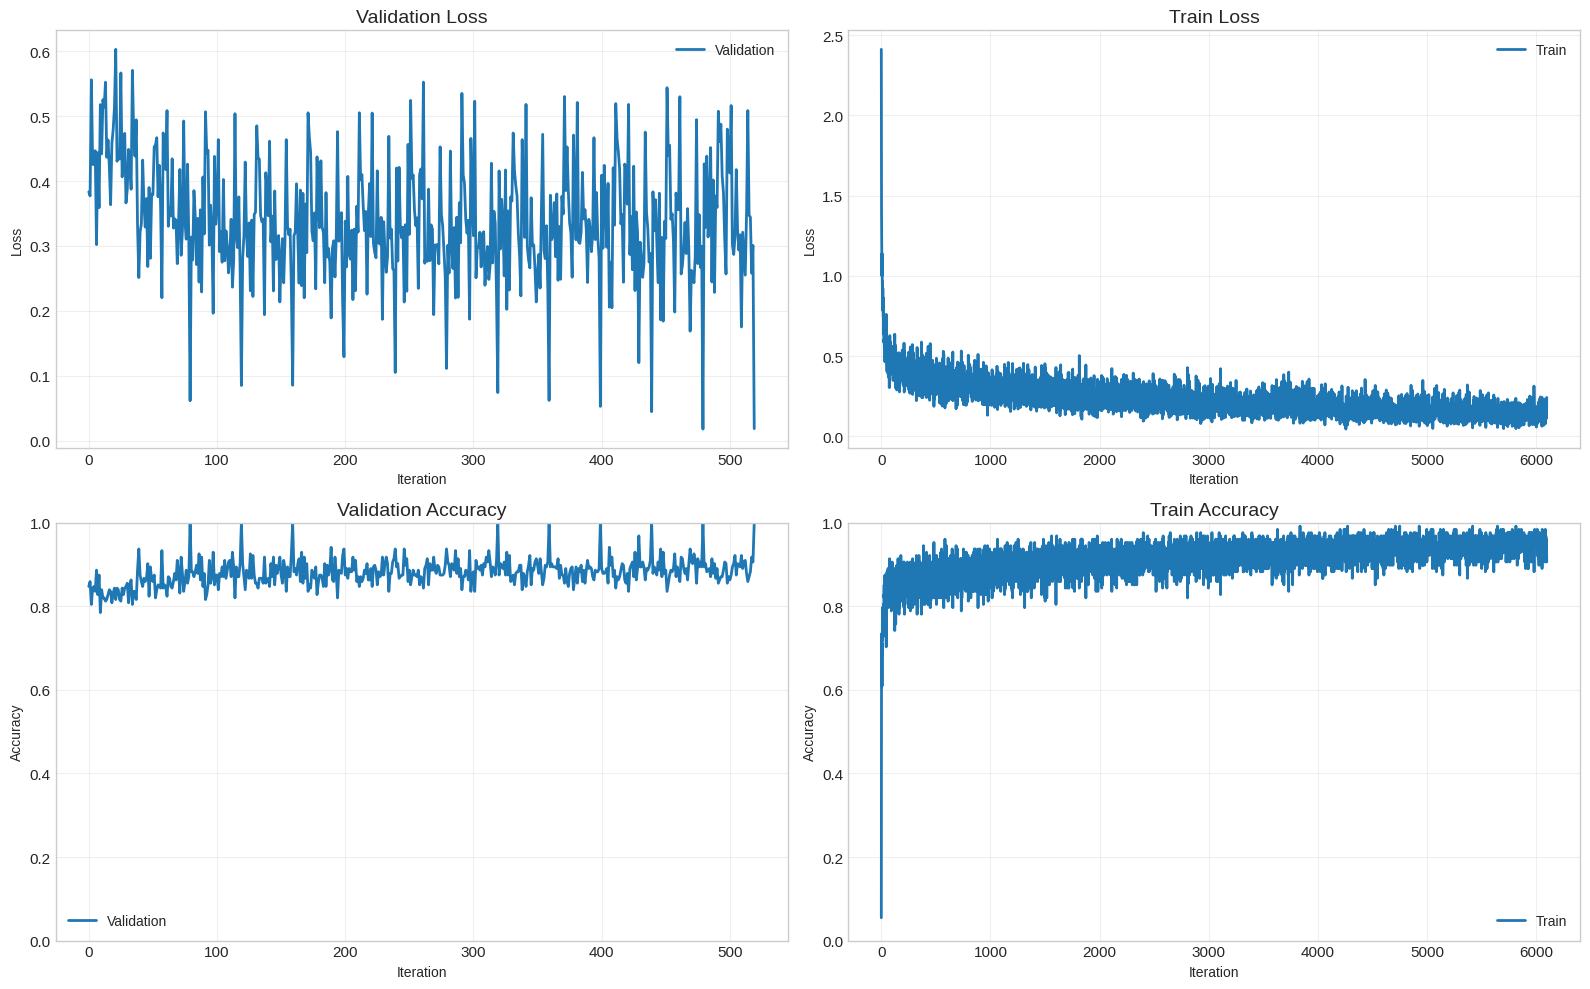

In [28]:
n_epochs = 13 

train_loss, val_loss, val_accuracy, train_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)


In [29]:

np.mean(val_accuracy)

np.float64(0.8813551682692308)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [30]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape * 8),
            nn.ReLU(),
            nn.Linear(input_shape * 8, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [31]:
n_epochs = 20
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

train_loss1, val_loss1, val_accuracy1, train_accuracy1 = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

[Epoch 1/20] loss/train=0.5472 loss/val=0.4399 time=4.54s
[Epoch 2/20] loss/train=0.4633 loss/val=0.4131 time=4.56s
[Epoch 3/20] loss/train=0.4225 loss/val=0.3952 time=4.57s
[Epoch 4/20] loss/train=0.3954 loss/val=0.3901 time=4.59s
[Epoch 5/20] loss/train=0.3755 loss/val=0.3818 time=4.61s
[Epoch 6/20] loss/train=0.3592 loss/val=0.3768 time=4.41s
[Epoch 7/20] loss/train=0.3460 loss/val=0.3713 time=4.38s
[Epoch 8/20] loss/train=0.3345 loss/val=0.3674 time=4.40s
[Epoch 9/20] loss/train=0.3246 loss/val=0.3653 time=4.48s
[Epoch 10/20] loss/train=0.3152 loss/val=0.3616 time=4.47s
[Epoch 11/20] loss/train=0.3068 loss/val=0.3595 time=4.50s
[Epoch 12/20] loss/train=0.2991 loss/val=0.3585 time=4.60s
[Epoch 13/20] loss/train=0.2916 loss/val=0.3575 time=4.55s
[Epoch 14/20] loss/train=0.2849 loss/val=0.3554 time=4.50s
[Epoch 15/20] loss/train=0.2785 loss/val=0.3543 time=4.49s
[Epoch 16/20] loss/train=0.2723 loss/val=0.3546 time=4.49s
[Epoch 17/20] loss/train=0.2667 loss/val=0.3552 time=4.52s
[Epoch

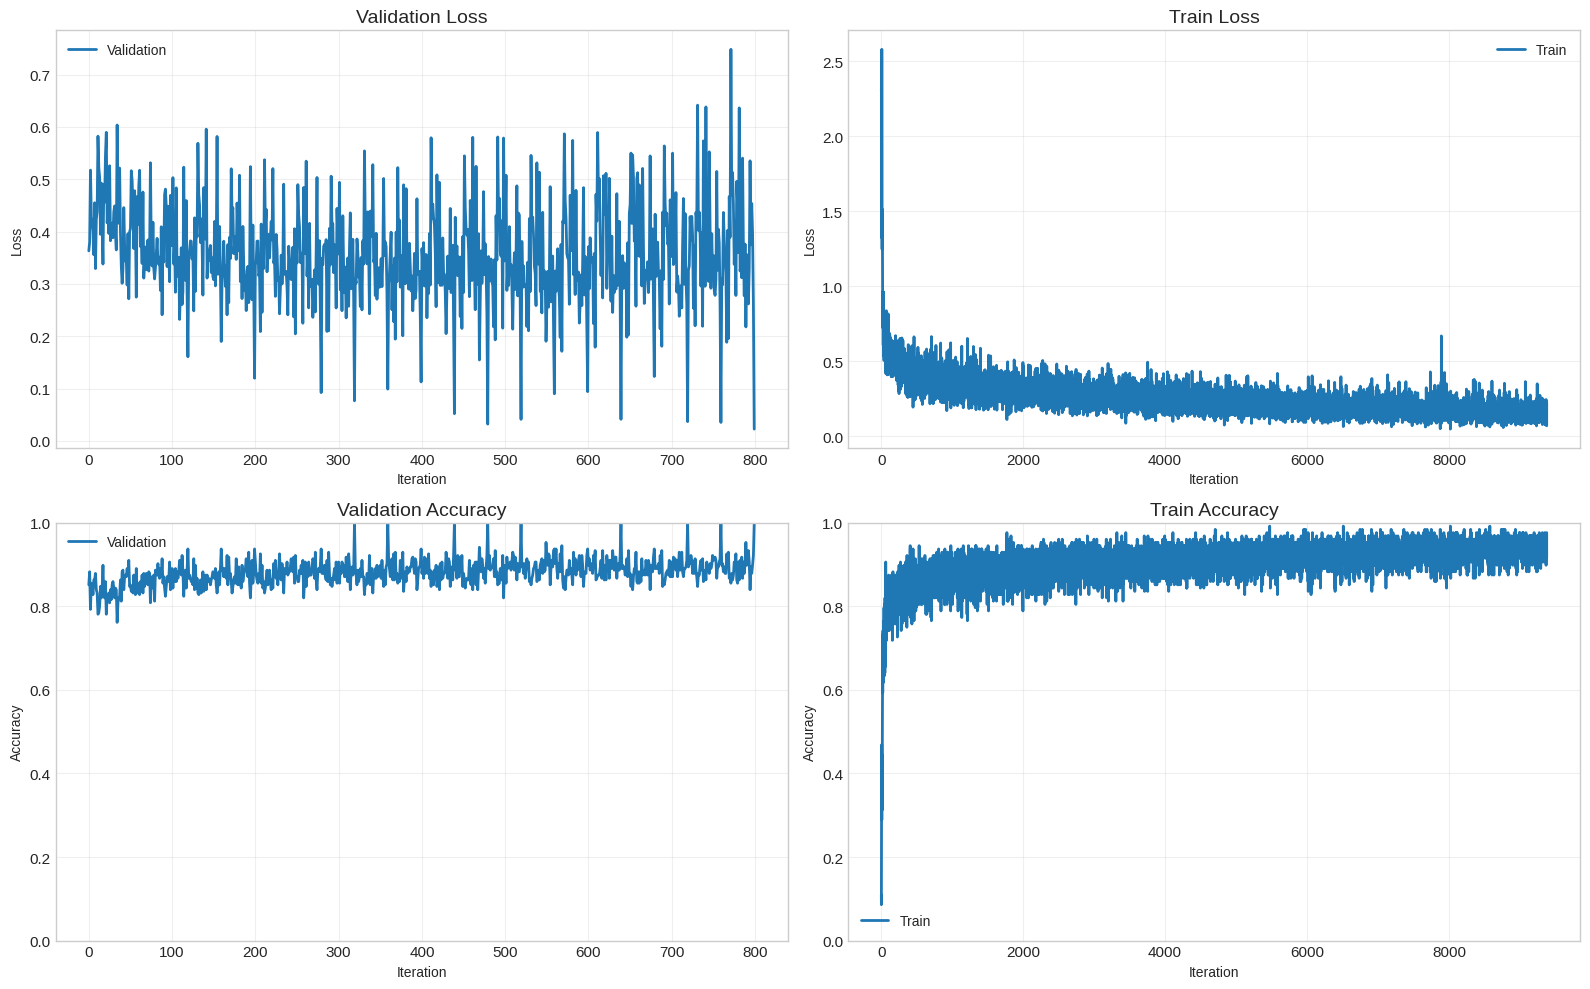

In [32]:
plot_metrics(train_loss1, val_loss1, train_accuracy1, val_accuracy1)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [33]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(0.5),
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape * 2),
            nn.Linear(input_shape * 2, input_shape * 8),
            nn.Dropout(0.75),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape * 8),
            nn.Linear(input_shape * 8, input_shape * 2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape * 2),
            nn.Linear(input_shape * 2, input_shape * 1),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.BatchNorm1d(num_classes)
        )
        
    def forward(self, inp):
        return self.model(inp)

In [34]:
n_epochs = 20
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

train_loss_fixed, val_loss_fixed, val_accuracy_fixed, train_accuracy_fixed = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

[Epoch 1/20] loss/train=0.7671 loss/val=0.5175 time=4.78s
[Epoch 2/20] loss/train=0.6763 loss/val=0.4873 time=4.79s
[Epoch 3/20] loss/train=0.6240 loss/val=0.4647 time=4.78s
[Epoch 4/20] loss/train=0.5908 loss/val=0.4464 time=4.80s
[Epoch 5/20] loss/train=0.5668 loss/val=0.4342 time=4.79s
[Epoch 6/20] loss/train=0.5477 loss/val=0.4238 time=4.78s
[Epoch 7/20] loss/train=0.5320 loss/val=0.4176 time=4.82s
[Epoch 8/20] loss/train=0.5193 loss/val=0.4108 time=4.80s
[Epoch 9/20] loss/train=0.5089 loss/val=0.4064 time=4.78s
[Epoch 10/20] loss/train=0.4991 loss/val=0.4013 time=4.81s
[Epoch 11/20] loss/train=0.4904 loss/val=0.3972 time=4.81s
[Epoch 12/20] loss/train=0.4829 loss/val=0.3933 time=4.83s
[Epoch 13/20] loss/train=0.4760 loss/val=0.3895 time=4.80s
[Epoch 14/20] loss/train=0.4697 loss/val=0.3858 time=4.81s
[Epoch 15/20] loss/train=0.4638 loss/val=0.3820 time=4.84s
[Epoch 16/20] loss/train=0.4585 loss/val=0.3797 time=4.79s
[Epoch 17/20] loss/train=0.4535 loss/val=0.3775 time=4.82s
[Epoch

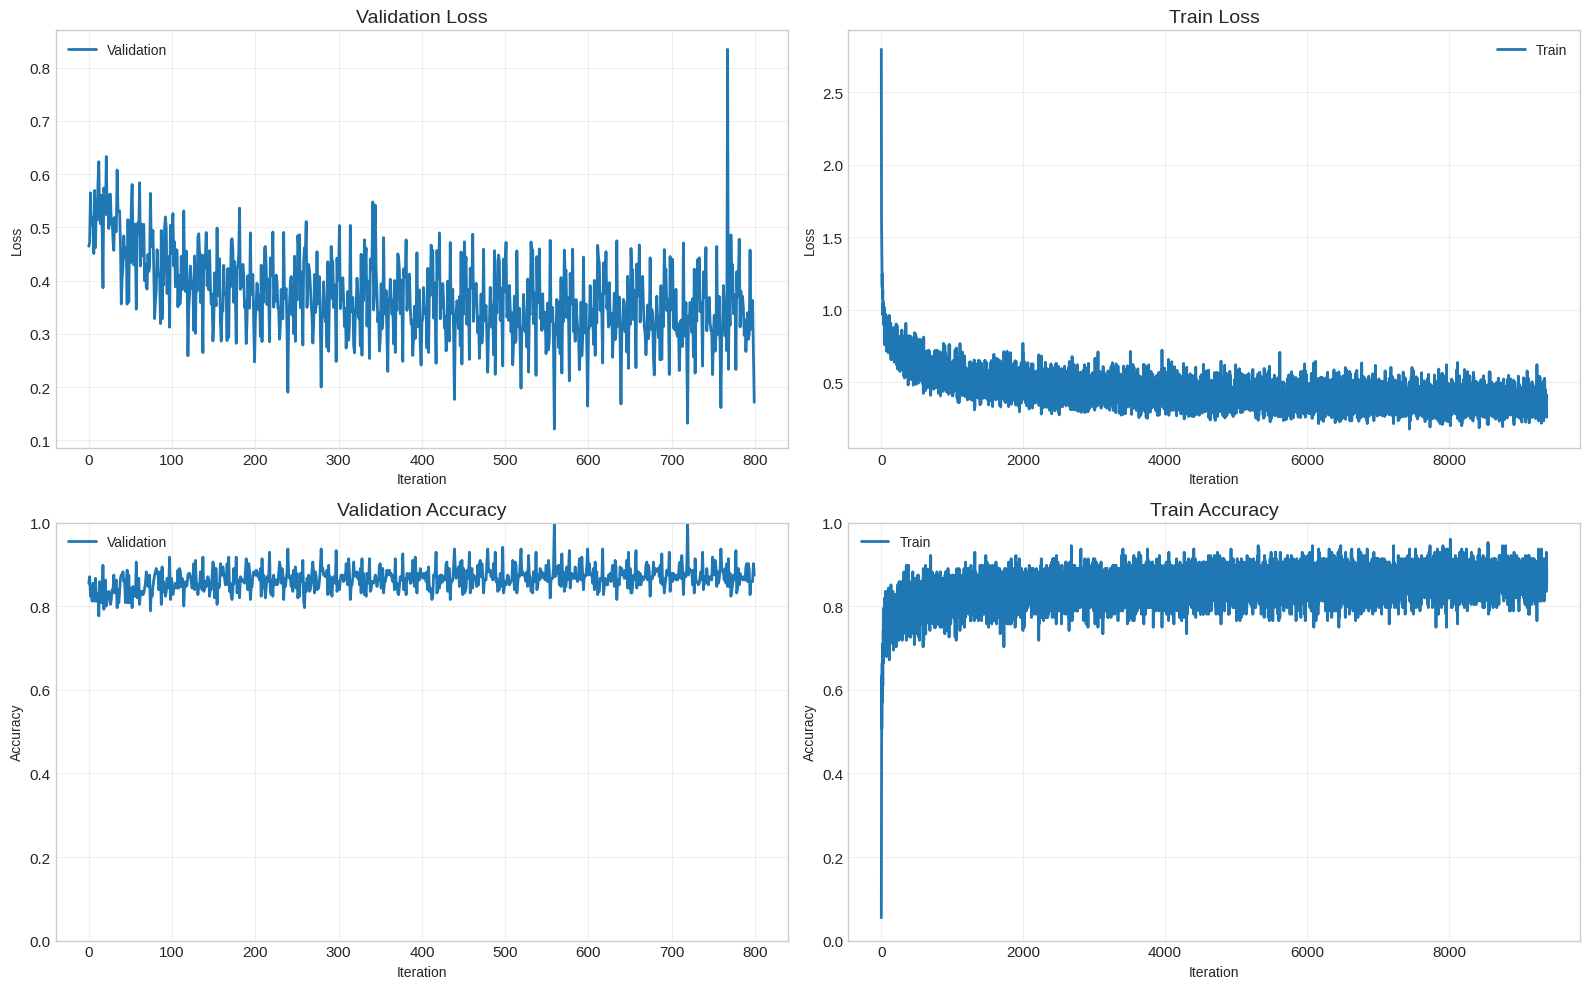

In [35]:
plot_metrics(train_loss_fixed, val_loss_fixed, train_accuracy_fixed, val_accuracy_fixed)

### Conclusions:
_Write down small report with your conclusions and your ideas._

1. Плавное снижение через Linear -> BatchNorm -> Activation func вполне дает результаты
2. Повышение числа параметров позволяет переобучить модель
3. Droupout и BatchNorm позволяют пофиксить модель 